In [1]:
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

In [2]:
q1, q2, q3 = me.dynamicsymbols('q1, q2, q3')

In [3]:
u1, u2, u3 = me.dynamicsymbols('u1, u2, u3')

In [4]:
F, T = me.dynamicsymbols('F, T')

In [5]:
k, c, ma, mb, mc, IB_bo, l, kT, g = sm.symbols('k, c, m_a, m_b, m_c, I_{B_bo}, l, k_T, g')
k, c, ma, mb, mc, IB_bo, l, kT, g

In [6]:
N = me.ReferenceFrame('N')
B = N.orientnew('B', 'Axis', (q2, N.z))
C = B.orientnew('C', 'Axis', (q3, N.z))

In [7]:
O = me.Point('O')
Pab = O.locatenew('P_{ab}', q1 * N.x)
Bo = Pab.locatenew('B_o', - 2 * l / 3 * B.y)
Pbc = Pab.locatenew('P_{bc}', -l * B.y)
Pc = Pbc.locatenew('P_c', -l * C.y)
Pc.pos_from(O)

In [8]:
Pab.set_vel(N, Pab.pos_from(O).dt(N))
Pab.vel(N)

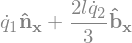

In [9]:
Bo.v2pt_theory(Pab, N, B)

In [10]:
Pbc.v2pt_theory(Pab, N, B)

In [11]:
Pc.v2pt_theory(Pbc, N, C)

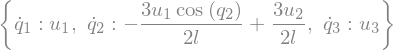

In [12]:
u1_eq = sm.Eq(u1, Pab.vel(N).dot(N.x))
u2_eq = sm.Eq(u2, Bo.vel(N).dot(B.x))
u3_eq = sm.Eq(u3, C.ang_vel_in(B).dot(B.z))
qdots = sm.solve([u1_eq, u2_eq, u3_eq], q1.diff(), q2.diff(), q3.diff())
qdots

In [13]:
Pab.set_vel(N, Pab.vel(N).subs(qdots).simplify())
Pab.vel(N)

In [14]:
Bo.set_vel(N, Bo.vel(N).subs(qdots).express(B).simplify())
Bo.vel(N)

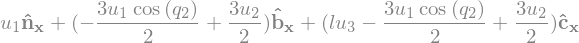

In [15]:
Pc.set_vel(N, Pc.vel(N).subs(qdots).simplify())
Pc.vel(N)

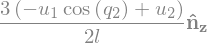

In [16]:
B.set_ang_vel(N, B.ang_vel_in(N).subs(qdots).simplify())
B.ang_vel_in(N)

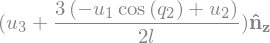

In [17]:
C.set_ang_vel(B, u3 * N.z)
C.ang_vel_in(N)

In [18]:
ma, mc

In [19]:
IB = me.inertia(B, 0, 0, IB_bo)
IB

In [20]:
Rab = (F - k*q1 - c*qdots[q1.diff()]) * N.x
Rab

In [21]:
Rbo = -(mb*g)*N.y
Rbo

In [22]:
Rc = -(mc*g)*N.y
Rc

In [23]:
TB = (T + kT*q3)*N.z
TB

In [24]:
TC = -kT*q3*N.z
TC

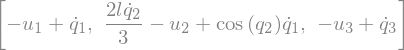

In [25]:
kdes = [u1_eq.rhs - u1_eq.lhs,
        u2_eq.rhs - u2_eq.lhs,
        u3_eq.rhs - u3_eq.lhs]
kdes

In [26]:
block = me.Particle('block', Pab, ma)
pendulum = me.RigidBody('pendulum', Bo, B, mb, (IB, Bo))
bob = me.Particle('bob', Pc, mc)

bodies = [block, pendulum, bob]

In [27]:
loads = [(Pab, Rab),
         (Bo, Rbo),
         (Pc, Rc),
         (B, TB),
         (C, TC)]

In [28]:
kane = me.KanesMethod(N, (q1, q2, q3), (u1, u2, u3), kd_eqs=kdes)
fr, frstar = kane.kanes_equations(bodies, loads=loads)

In [29]:
from pydy.system import System
import numpy as np  # provides basic array types and some linear algebra
import matplotlib.pyplot as plt  # used for plots

In [30]:
sys = System(kane)

In [31]:
sys.constants = {ma: 1.0,  # kg
                 mb: 2.0,  # kg
                 mc: 1.0,  # kg
                 g: 9.81,  # m/s/s
                 l: 2.0,  # m
                 IB_bo: 2.0,  # kg*m**2
                 c: 10.0,  # kg/s
                 k: 60.0,  # N/m
                 kT: 10.0}  # N*m/rad

In [32]:
sys.times = np.linspace(0.0, 20.0, num=500)

In [33]:
sys.states

In [34]:
sys.initial_conditions = {q1: 1.0,  # m
                          q2: 0.0,  # rad
                          q3: 0.0,  # rad
                          u1: 0.0,  # m/s
                          u2: 0.0,  # rad/s
                          u3: 0.0}  # rad/s

In [35]:
specifieds = {F: 0.0,  # N
              T: 1.0}  # N*m

In [36]:
specifieds = {(F, T): np.array([0.0, 1.0])}

In [37]:
def sin_f(x, t):
    """Returns the force F given the state vector x and time value t.

    Parameters
    ==========
    x : ndarray, shape(n,)
        The states in the order specified in System.states.
    t : float
        The value of time.

    Returns
    =======
    float
        The value of the force at time t.

    """
    return 1.0 * np.sin(2 * np.pi * t)

specifieds = {F: sin_f,  # N
              T: 1.0}  # N*m

In [38]:
def sin_f_t(x, t):
    return  np.array([5.0 * np.sin(2.0 * np.pi * t),
                      10.0 * np.cos(2.0 * np.pi * t)])

specifieds = {(F, T): sin_f_t}

In [39]:
sys.specifieds = specifieds

In [40]:
x = sys.integrate()
x.shape

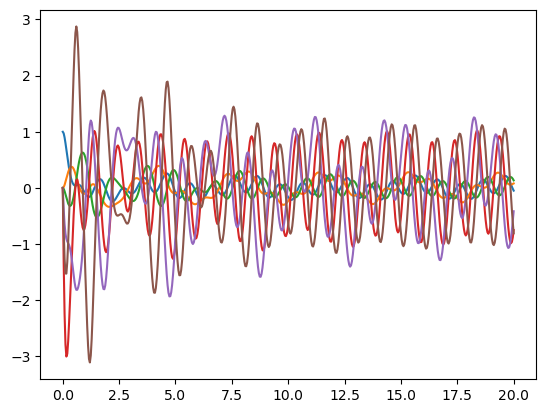

In [41]:
plt.plot(sys.times, x);

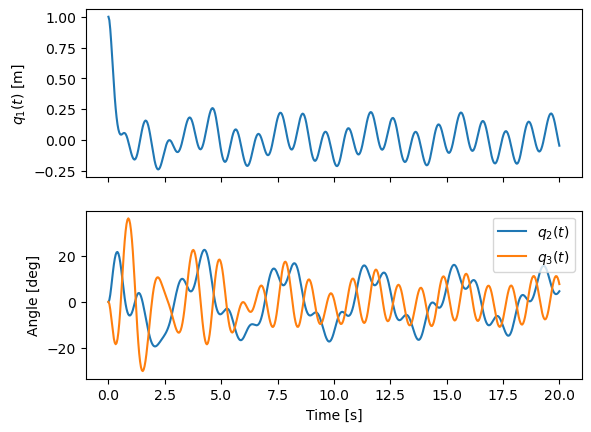

In [42]:
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(sys.times, x[:, 0])
axes[0].set_ylabel('{} [m]'.format(sm.latex(q1, mode='inline')))
axes[1].plot(sys.times, np.rad2deg(x[:, 1:3]))
axes[1].legend([sm.latex(q, mode='inline') for q in (q2, q3)])
axes[1].set_xlabel('Time [s]')
axes[1].set_ylabel('Angle [deg]');

In [43]:
from pydy.viz.shapes import Cube, Cylinder, Sphere, Plane
from pydy.viz.visualization_frame import VisualizationFrame
from pydy.viz import Scene

In [44]:
block_shape = Cube(0.25, color='azure', name='block')
cpendulum_shape = Plane(l, l/4, color='mediumpurple', name='cpendulum')
spendulum_shape = Cylinder(l, 0.02, color='azure', name='spendulum')
bob_shape = Sphere(0.2, color='mediumpurple', name='bob')

In [45]:
v1 = VisualizationFrame('block', N, Pab, block_shape)

v2 = VisualizationFrame('cpendulum',
                        B,
                        Pab.locatenew('Bc', -l/2*B.y),
                        cpendulum_shape)

v3 = VisualizationFrame('spendulum',
                        C,
                        Pbc.locatenew('Cc', -l/2*C.y),
                        spendulum_shape)

v4 = VisualizationFrame('bob', C, Pc, bob_shape)

In [46]:
scene = Scene(N, O, v1, v2, v3, v4, system=sys)

In [47]:
scene.display_jupyter(axes_arrow_length=1.0)

In [48]:
sys.initial_conditions[q1] = 5.0  # m

In [49]:
scene.display_jupyter(axes_arrow_length=1.0)